<a href="https://colab.research.google.com/github/luckysouthchou/pytorch_udemy/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip3 install torch torchvision


In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms



In [0]:
#image = (image - mean) / std
'''If you read the documentation here 872, you will see that both parameters are “Sequences for each channel”. Color images have three channels (red, green, blue), therefore you need three parameters to normalize each channel. The first tuple (0.5, 0.5, 0.5) is the mean for all three channels and the second (0.5, 0.5, 0.5) is the standard deviation for all three channels.'''

transform =  transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                                ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)

In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  #1, 28, 28 >> 28, 28, 1 (1 is channel) (C, H, W)(channel, height, weight)
  #denormalization
  #print(image.shape)
  image = image * np.array((0.5)) + np.array(0.5)
  image = image.clip(0, 1)
  #small than0, become 0, bigger than 1, become 1: .clip()
  return image

In [41]:
#For example, such a dataset, when called iter(dataset), could return a stream of data reading from a database, a remote server, or even logs generated in real time.
dataiter  = iter(training_loader)
images, labels = dataiter.next()
'''
fig = plt.figure(figsize = (25, 4))
#weight, height of the figure(25, 4)
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])
  '''

'\nfig = plt.figure(figsize = (25, 4))\n#weight, height of the figure(25, 4)\nfor idx in np.arange(20):\n  ax = fig.add_subplot(2, 10, idx+1)\n  plt.imshow(im_convert(images[idx]))\n  ax.set_title([labels[idx].item()])\n  '

In [42]:
class Classfier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x

model = Classfier(784, 125, 65, 10)
model


Classfier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
#we can reset the learning rates to 0.001 even 0.0001to have a good prediction

In [50]:
epochs = 12
running_loss_history = []
#store loss of every epoch
running_correct_history = []
#accuracy of every epoch


for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  #inistiate accuract value = 0.00
  for inputs, labels in training_loader: 
    inputs = inputs.view(inputs.shape[0], -1)
    #1, 784(1 channel, 28 * 28), make image 1 dimentional  
    outputs = model(inputs)
    #model using linear first, then using softmax to transfer the number into probabiloities, if the model is more sinple. softmax can be sigmoid function to transfer the number into probability
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    #return the index of the maximum probability value for that image
    running_corrects += torch.sum(preds == labels.data)

    running_loss += loss.item()
    #running loss: loss plus per batch
  else:
    epoch_loss = running_loss / len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    #epoch_loss : loss of every epoch
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)
    print('training loss: {:.4f}'.format(epoch_loss))
    print('trainig accuracy: {:.4f}'.format(epoch_acc.item()))

training loss: 0.1463
trainig accuracy: 95.7483
training loss: 0.1380
trainig accuracy: 95.9917
training loss: 0.1307
trainig accuracy: 96.2033
training loss: 0.1241
trainig accuracy: 96.3550
training loss: 0.1171
trainig accuracy: 96.6250
training loss: 0.1110
trainig accuracy: 96.7817
training loss: 0.1058
trainig accuracy: 96.9200
training loss: 0.1015
trainig accuracy: 97.0500
training loss: 0.0965
trainig accuracy: 97.2033
training loss: 0.0921
trainig accuracy: 97.3467
training loss: 0.0890
trainig accuracy: 97.3983
training loss: 0.0847
trainig accuracy: 97.5800


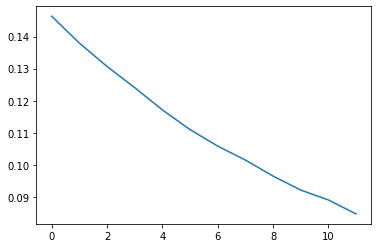

In [51]:
plt.plot(running_loss_history, label = 'training loss')

In [0]:
#this graph is fluctuated, so reset the learning rates to a more minor vakue 0.01>>>> 0.001>>>>>0.0001, and run the program again

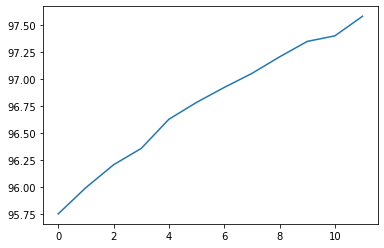

In [53]:
plt.plot(running_correct_history, label = 'training accuracy')